# Streaming MegaLab Camera with Community Fish Detector

This is a project I've wanted to do for some time. Ever since I've known about the [The MegaLab](https://themegalab.org/) and the live stream camera they have, I've wanted to apply some computer vision models on it, or at the very least, just collect some data from it.

Well now I have, or am, as of writing this, doing just that.

Recently, another organization called [Wildhackers](https://www.wildhackers.net) beat me to the punch (quite literally) by training a large object detection model using many open-sourced fish datasets from around the work to be able to generically detect fish in the wild from any source. 

They call this model the [Community Fish Detector](https://github.com/WildHackers/community-fish-detector) and have made it open source for anyone to use. Of course, it's utilizing the Ultralytics YOLO architecture which makes it by default a AGPL licensed model. But that's okay, because this is open-sourced work too!

In addition, cool enough, this stream from Megalab also an audio source! And seeing as how I just got done writing a post about [generating spectrograms with Gstreamer](https://jackmead515.github.io/notebooks/spectrogram_generation.html), I think it would be fun to also grab the audio stream as well, and do something fun with it! I don't know the quality of the hydrophone audio, but we will soon discover that!

So this project demonstrated here, will attempt to setup a live stream from the MegaLab camera using Gstreamer, run inferencing acrossed the frames, but also decoding the audio stream and generate a spectrogram video! Quite a feature packed project! Let's gggoooooooo!!!

To start, we have to grab the live stream from the MegaLab camera. They currently broadcast their stream over Youtube for all to see. But Youtube utilizes HLS streaming too, for which we can use Gstreamer to read from. But on purpose, Youtube makes it a bit tricky to get the actual HLS playlist URL. I believe after reviewing the terms of service that reading this directly from some script is not allowed (but I'm just gonna do it anyway. shhhhh... I'm sure they won't mind for a bit).

The tool `yt-dlp` is a great way to extract the actual HLS playlist URL from a Youtube video. So we can use that to get the URL, and then pass that into Gstreamer.

In [1]:
! yt-dlp --get-url "https://www.youtube.com/watch?v=UFA_SYoLqtk"

https://manifest.googlevideo.com/api/manifest/hls_playlist/expire/1763805988/ei/xDYhaf_oCreZsfIP97brwQ4/ip/98.151.109.154/id/UFA_SYoLqtk.1/itag/96/source/yt_live_broadcast/requiressl/yes/ratebypass/yes/live/1/sgoap/gir%3Dyes%3Bitag%3D140/sgovp/gir%3Dyes%3Bitag%3D137/rqh/1/hls_chunk_host/rr20---sn-ib.googlevideo.com/xpc/EgVo2aDSNQ%3D%3D/playlist_duration/30/manifest_duration/30/bui/AdEuB5RL-U6RHKUGmgYBynes5SExVgiANkTt05ot8hLNj-0F17RT6FjrnDblfhYNS8GsYj7ECMacVnLU/spc/6b0G_CFhsiM4f8J-0ZWuC5gaS7UEdIiD3HmjpsCfRbwAb_Jx0pDq_Ygdv0VNjOfFXRI/vprv/1/playlist_type/DVR/cps/77/initcwndbps/3011250/met/1763784388,/mh/mc/mm/44/mn/sn-ib/ms/lva/mv/m/mvi/20/pl/24/rms/lva,lva/dover/11/pacing/0/keepalive/yes/fexp/51355912,51552689,51565115,51565681,51580968/mt/1763784031/sparams/expire,ei,ip,id,itag,source,requiressl,ratebypass,live,sgoap,sgovp,rqh,xpc,playlist_duration,manifest_duration,bui,spc,vprv,playlist_type/sig/AJfQdSswRAIgKbwygFg1I5ErOu1JMkXMC1I86x71zh3oIv7p-N9XPyECIA6BbAEcT2QJN0E9P9OekGiWgoz-Ma3VOTn

Alright easy enough! Then, utilizing `gst-launch-1.0`, and some bash command substitution, we can read from the HLS stream like so:

In [2]:
! gst-launch-1.0 souphttpsrc location="$(yt-dlp --get-url "https://www.youtube.com/watch?v=UFA_SYoLqtk")" is-live=1 ! decodebin ! videoconvert ! autovideosink

Setting pipeline to PAUSED ...
Pipeline is live and does not need PREROLL ...
Got context from element 'souphttpsrc0': gst.soup.session=context, session=(GstSoupSession)NULL;
Pipeline is PREROLLED ...
Setting pipeline to PLAYING ...
New clock: GstSystemClock
Got context from element 'souphttpsrc1': gst.soup.session=context, session=(GstSoupSession)NULL;
Got context from element 'souphttpsrc1': gst.soup.session=context, session=(GstSoupSession)NULL;
Redistribute latency...
Redistribute latency...
Redistribute latency...
Got context from element 'souphttpsrc1': gst.soup.session=context, session=(GstSoupSession)NULL;
Got context from element 'souphttpsrc1': gst.soup.session=context, session=(GstSoupSession)NULL;
Got context from element 'souphttpsrc1': gst.soup.session=context, session=(GstSoupSession)NULL;
handling interrupt.9.
Interrupt: Stopping pipeline ...
Execution ended after 0:00:07.538806387
Setting pipeline to NULL ...
Freeing pipeline ...
^C


You'll have to trust me that this works because I can't really show a video in this notebook. But it's confirmed, we got stream and we can see the fish swimming around! We can now begin to write our Gstreamer pipeline to do the inferencing.

I won't provide all the code here in the notebook, as it's quite lengthy, but I will showcase the important parts.

First, we setup a Gstreamer pipeline to read from the HLS source, decode both the audio and video streams, and then send them to appsinks for us to read from in Python.

```python
hls_source = [...retrieved using yt-dlp...]
fps = 30

source_pipeline = f'''
appsink name=videoread emit-signals=true \
appsink name=audioread emit-signals=true \
souphttpsrc location="{hls_source}" is-live=true \
! hlsdemux \
! tsdemux name=demux \
demux. \
    ! tee name=video_tee \
    video_tee. \
    ! queue \
    ! h264parse \
    ! avdec_h264 \
    ! videoconvert \
    ! videorate \
    ! video/x-raw,format=RGB,framerate={fps}/1 \
    ! videoread. \
demux. \
    ! tee name=audio_tee \
    audio_tee. \
    ! queue \
    ! aacparse \
    ! faad \
    ! audioconvert \
    ! audioresample \
    ! audiobuffersplit output-buffer-duration=1/{fps} \
    ! audioread.
'''.strip()

source_pipeline = Gst.parse_launch(source_pipeline)

video_source = source_pipeline.get_by_name("videoread")
audio_source = source_pipeline.get_by_name("audioread")
```

This gstreamer pipeline should do the trick. We have two appsinks, one for the video frames, and one for the audio buffers. We then demux the HLS stream, demux the MPEG-TS segments, and then direct them to seperate threads (utilizing tees and queues), decode them, convert them to a usable format, and then send them to the appsinks. For the video, we convert it to RGB format so it's easy to load into a numpy array later. For the audio, we split the audio buffers into smaller chunks of 1/30th of a second, that way, our audio processing will match the frame rate of the video (30 FPS).

To reshape the video frames, it's as simple as:

```python
def on_video_sample(sink):
    sample = sink.emit("pull-sample")
    buffer = sample.get_buffer()
    caps = sample.get_caps()
    success, map_info = buffer.map(Gst.MapFlags.READ)

    if not success:
        return Gst.FlowReturn.ERROR

    frame = np.frombuffer(map_info.data, dtype=np.uint8)
    frame = frame.reshape((1920, 1080, 3))

    # boom!

    buffer.unmap(map_info)
    return Gst.FlowReturn.OK

video_source.connect("new-sample", lambda sink: on_video_sample(sink))
```

For the audio buffers, it's a little more involved. In my previous post on spectogram data, I actually didn't generate the spectrogram correctly. You see, the AAC audio codec does something called Spectral Band Replication (SBR). In SBR, the top half of the frequencies literally just get cut from the entire audio spectrum, and only the bottom half is encoded. From a human listening perspective, this is fine actually because the higher frequencies don't add much to the audio quality (but certainly do add to the file size). So in AAC, it passes packets that indicate to the decoder how to "reconstruct" the higher frequencies from the lower frequencies (essentially mirroring them but at a lower quality). This creates a nice illusion of higher quality audio without actually having to encode the higher frequencies.

What does this mean for spectograms? It means our spectrograms are gonna look weird if we don't handle this properly. Like this:

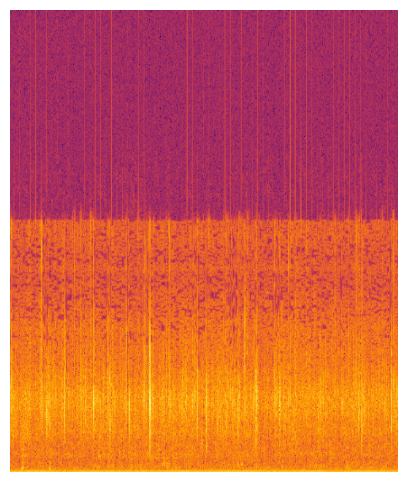

In [1]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("debug_spectrogram.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))
plt.imshow(image)
plt.axis("off")
plt.show()

We can safely just cut the upper half of the spectrogram off, since we know it's just a mirrored version of the lower half. So in our audio processing code, we do just that:

```python
def on_audio_sample(sink):
    global spect_image

    sample = sink.emit("pull-sample")
    buffer = sample.get_buffer()
    success, map_info = buffer.map(Gst.MapFlags.READ)

    if not success:
        return Gst.FlowReturn.ERROR

    data = map_info.data
    
    # the caps say S16LE, so we interpret the buffer as int16
    tensor = np.frombuffer(data, dtype=np.int16).copy()

    # this is two channel audio, reshape accordingly
    tensor = tensor.reshape(-1, 2).T

    # use only the first channel
    tensor = tensor[0, :]
    
    # generate spectrogram
    tensor = power_to_db(spec_transform(t.from_numpy(tensor).float()))

    # flip the spectrogram vertically so the high frequencies are at the top
    tensor = np.flipud(tensor.numpy())

    # crop part of the spectrogram into a buffer.
    # this is faster than recomputing the entire spectrogram each time
    spect_image[:, :-tensor.shape[1]] = spect_image[:, tensor.shape[1]:]
    spect_image[:, -tensor.shape[1]:] = tensor

    # normalize spect_image to 0-255
    norm_image = spect_image - spect_image.min()
    norm_image = norm_image / (norm_image.max() + 1e-6)
    norm_image = norm_image * 255.0
    norm_image = norm_image.astype(np.uint8)
    
    # apply color map. Inferno looks nice!
    norm_image = cv2.applyColorMap(norm_image, cv2.COLORMAP_INFERNO)
    norm_image = cv2.cvtColor(norm_image, cv2.COLOR_BGR2RGB)

    # cut off the upper half. Since the AAC codec applies
    # Spectoral Band Replication (SBR), the higher frequencies
    # are just copies of the lower frequencies.
    norm_image = norm_image[spect_image_height//2:, :]

    # resize to a standardize size. Some slight distortion is ok.
    norm_image = cv2.resize(norm_image, (spect_video_width, spect_video_height), interpolation=cv2.INTER_AREA)

    video_buffer = Gst.Buffer.new_wrapped(norm_image.tobytes())
    video_buffer.pts = buffer.pts
    video_buffer.duration = buffer.duration

    audio_buffer = Gst.Buffer.new_wrapped(data)
    audio_buffer.pts = buffer.pts
    audio_buffer.duration = buffer.duration

    audio_write.emit("push-buffer", audio_buffer)
    spect_write.emit("push-buffer", video_buffer)

    buffer.unmap(map_info)

    return Gst.FlowReturn.OK
```

Okay, so this being the full audio processing code, we write to the `audio_write` and `spect_write` appsinks at the end. We will loop back to this. But first, we still need to inference on the video frames to detect fish!

The Ultralytics framework is much simpler to setup than this lengthy audio processing code. We just load the model, and then call the model on the frames we get from Gstreamer.

```python
from ultralytics import YOLO

model = YOLO("cfd-yolov12x-1.00.pt", verbose=False, task="detect")

#
#
# in the video sample callback
#
#

frame = np.frombuffer(map_info.data, dtype=np.uint8)
frame = frame.reshape((video_height, video_width, 3))

results = model(frame, imgsz=640, verbose=False)
image = results[0].plot(color_mode="class")
image = cv2.resize(image, (video_width, video_height))

frame_buffer = Gst.Buffer.new_wrapped(image.tobytes())
frame_buffer.pts = buffer.pts
frame_buffer.duration = buffer.duration

video_write.emit("push-buffer", frame_buffer)
```

So simple! Ultralytics will already detect the GPU if available, and process the frames quickly.

Now we have to setup the output Gstreamer pipeline to record this data to a file. It goes a little something like this:

```python
sink_pipeline = f'''
appsrc name=videowrite emit-signals=true format=time is-live=true \
appsrc name=audiowrite emit-signals=true format=time is-live=true \
appsrc name=spectwrite emit-signals=true format=time is-live=true \
matroskamux name=mux \
    ! filesink location="output.mkv" \
compositor name=mix background=black sink_1::xpos=20 sink_1::ypos={video_height - spect_video_height - 20} sink_1::alpha=0.9 \
    ! video/x-raw,width={video_width},height={video_height} \
    ! videoconvert \
    ! videorate \
    ! video/x-raw,framerate={fps}/1,format=I420 \
    ! x264enc tune=zerolatency speed-preset=ultrafast \
    ! h264parse config-interval=-1 \
    ! mux. \
videowrite. \
    ! queue \
    ! videoconvert \
    ! mix.sink_0 \
spectwrite. \
    ! queue \
    ! videoconvert \
    ! mix.sink_1 \
audiowrite. \
    ! queue \
    ! audioconvert \
    ! flacenc \
    ! mux.
'''
sink_pipeline = Gst.parse_launch(sink_pipeline)

video_write = sink_pipeline.get_by_name("videowrite")
audio_write = sink_pipeline.get_by_name("audiowrite")
spect_write = sink_pipeline.get_by_name("spectwrite")

video_caps = Gst.Caps.from_string(f"video/x-raw,format=RGB,width={video_width},height={video_height},framerate={fps}/1")
audio_caps = Gst.Caps.from_string("audio/x-raw,format=S16LE,layout=interleaved,rate=44100,channels=2")
spect_caps = Gst.Caps.from_string(f"video/x-raw,format=RGB,width={spect_video_width},height={spect_video_height},framerate={fps}/1")

video_write.set_property('caps', video_caps)
audio_write.set_property('caps', audio_caps)
spect_write.set_property('caps', spect_caps)
```

The way this all works is that we have three appsrc elements, one for the video with bounding boxes drawn on it, one for the audio stream, and one for the spectrogram video. We first add a `compositor` element to overlay the spectrogram video on top of the main video, then encode that to H.264, at the same time we encode the audio to FLAC, and then mux them both into a Matroska container file!

It's very important to set the caps on the appsrc elements. Since these are two seperate pipelines (the source and sink), they cannot exchange caps information automatically. So we have to manually set them.

Finally, we just start both pipelines and let it run! I was originally going to re-stream this out to an RTSP server like MediaMTX, but I figured that it was a bit much for this demo. Just the fact that we are able to perform this magic on the video stream is enough for me!

But if you let your imagination run wild, streaming this out to an RTSP server is very doable. Could even set this up to stream right back into a Youtube live stream if you wanted to! You could split the spectrogram and audio into a second stream to do machine learning on that data too.

When reviewing the audio and spectrograms, There is plenty of noise out there on the reef. One notable sound is the crunch of fish as they scrap food off the coral. It's quite loud and distinct and viewable within the spectrogram. Other than the audio, the community fish detector model works pretty well right off the bat. It mainly detects the larger fish in view, and with applied tracking, we could track their movements over time.

In [ ]:
from IPython.display import Video

Video('https://jackmead515.github.io/videos/megalab_detected.mp4', html_attributes='loop autoplay muted playsinline width="100%"')

If you want to hear the audio, you'll have to view the video file directly. And, in addition, the full code for this is avaliable here: [megalab detector stream](https://github.com/jackmead515/jackmead515.github.io/blob/main/code/megalab_stream.py).

This was such a fun project. You know as an engineer, when you get that feeling that you just want to stay indoors and code as fast as you can on this new idea you have? That's exactly how I felt while working on this: taking a Friday night and Saturday morning just cranking this one out.

I just felt so inspired and fasinated with all the possibilities of what could be done with this data, and how relatively easy it is to do with the tools we have today.

I can't wait to test this out on other streams and see what else we can discover!